# Deep Q-Network implementation (DQN) - with Prioritized Replay (PyTorch).

In this notebook, we will implement DQN with **experience replay** and **target networks**.
$$ \DeclareMathOperator*{\max}{max}$$
### Recap

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update. 

In case of function approximation using neural network, the input to the network is the state and output is the q(s,a) for all the actions in the state `s`. It is denoted as $ \hat{q}(s_t,a; w_{t}) $, where $w_{t}$ is the weights of the neural network which we are trying to learn as part of DQN learning. 

We use two networks, one target network to get the max q-value of next state denoted by $ \max_a \hat {q}(s_{t+1},a; w^{-}_{t}) $ and the primary network (online network) with weights $w_{t}$ which we are updated based on back propagation of the TD error through the network.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a,w^{-}_{t}) – \hat{q}(S_t,A_t,w_t)] \nabla \hat{q}(S_t,A_t,w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values. 

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions (current state, action, reward, next state) in a buffer. Where each sample is denoted as a tuple: 

$$ (s_{i}, a_{i}, r_{i}, s^{'}_{i}, done_{i})$$

Subscript (i) denotes ith sample. We take N samples from experience replay selecting randomly and update the weights. Subscript (t) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

import os
import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline


### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and they try to run this on many other environments like Atari games and others.


In [2]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

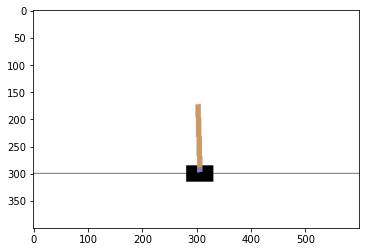

In [3]:
env_name = 'CartPole-v1'

env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, n_actions = env.observation_space.shape, env.action_space.n

### Building a network using pytorch

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 2 hidden layers with Relu activation and final layer being logits with dimension equal to number of actions. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (inout is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.network = nn.Sequential()
        self.network.add_module('layer1', nn.Linear(state_dim, 192))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('layer2', nn.Linear(192, 256))
        self.network.add_module('relu2', nn.ReLU())
        self.network.add_module('layer3', nn.Linear(256, 64))
        self.network.add_module('relu3', nn.ReLU())
        self.network.add_module('layer4', nn.Linear(64, n_actions))
        # 
        self.parameters = self.network.parameters
        
    def forward(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [6]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [8]:
print(evaluate(env, agent, n_games=1))
env.close()

15.0


### Prioritized Experience replay

In this notebook, we will use `Prioritized` version replay buffer as explained in the paper https://arxiv.org/pdf/1511.05952.pdf. 

Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

We will be using prioritized version of experience replay. 

The interface to PrioritizedReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `update_priorities(idxs, new_priorities)` - returns nothing. 
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In usual replay buffer, we select training batch with equal probability of selection for each sample/transition stored in the buffer. However, in Prioritized replay, we assign an importance score $p_i$ to each sample/transition. One approach to importance score is to use the absolute value of TD error $\delta_i$ with addition of small constant $\epsilon$ to avoid the edge case of error being zero and not picked up again ever.  

$$ p_i = |\delta_i| +\epsilon$$

$$\delta_i = r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t)$$


At the time of picking the batch samples from buffer, the individual importance scores for samples are converted to probability which defines the probability of a sample being picked:

$$P(i) = \frac{p_i^{\alpha}}{\sum_i p_i^{\alpha}}; \alpha=0.6 $$

$\alpha$ is a hyper parameter and in the paper cited above, a value of 0.6 was found to work the best. We are using the same value in our code below:


TD error for the samples chosen in the batch is used to calculate the loss and $\nabla_w(L)$. The TD error is also used to update the importance score $p_i$ of the samples back in the buffer. 


The probability $P(i)$ is also used to calculate a weight, an importance sampling value, to adjust for the fact that samples now have a non uniform probability of being picked. The weight vector for batch samples as given below:

$$w_i = \left(\frac{1}{N}.\frac{1}{P(i)} \right)^\beta; \beta=0.4$$

Value of $\beta=0.4$ has been taken from the paper cited above. 

While calculating the training loss, the individual TD errors $\delta_i$ are weighed by the weights $w_i$. The updated batch loss equation is shown a few cells below.

In [9]:
class PrioritizedReplayBuffer:
    def __init__(self, size, alpha=0.6, beta=0.4):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
        self.alpha = alpha
        self.beta = beta
        self.priorities = np.ones(size)
        self.epsilon = 1e-5
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        max_priority = self.priorities.max()
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.priorities[self.next_id] = max_priority
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        priorities = self.priorities[:len(self.buffer)]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        N = len(self.buffer)
        weights = (N * probabilities) ** (-self.beta)
        weights /= weights.max()

        idxs = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        weights = weights[idxs]
        
        
        return  (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(done_flags), np.array(weights), np.array(idxs))
        
    def update_priorities(self, idxs, new_priorities):
        self.priorities[idxs] = new_priorities+self.epsilon

In [10]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network


In [11]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation: 

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_w L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


$\hat{q}(s',A;w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network. 

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t})$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$ 
\DeclareMathOperator*{\max}{max} w_{t+1} \leftarrow w_t - \alpha \nabla_{w}L$$

In [12]:
def compute_td_loss_priority_replay(agent, target_network, replay_buffer,
                                    states, actions, rewards, next_states, done_flags, weights, buffer_idxs,
                                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)
    weights = torch.tensor(weights, device=device, dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values,_ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values" 
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)
    
    #compute each sample TD error
    loss = ((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2) * weights
    
    # mean squared error loss to minimize
    loss = loss.mean()
    
    # calculate new priorities and update buffer
    with torch.no_grad():
        new_priorities = predicted_qvalues_for_actions.detach() - target_qvalues_for_actions.detach()
        new_priorities = np.absolute(new_priorities.detach().numpy())
        replay_buffer.update_priorities(buffer_idxs, new_priorities)
        
    return loss

### Main loop

We now carryout the training on DQN setup above.

In [13]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [14]:
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [15]:
#setup env and agent and target networks
env_name = 'CartPole-v1'
env = make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [16]:
# let us fill experience replay with some samples using full random policy
exp_replay = PrioritizedReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))


10000


In [17]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 45000

#init Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [18]:
mean_rw_history = []
td_loss_history = []


In [19]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 10000, epsilon = 0.05000


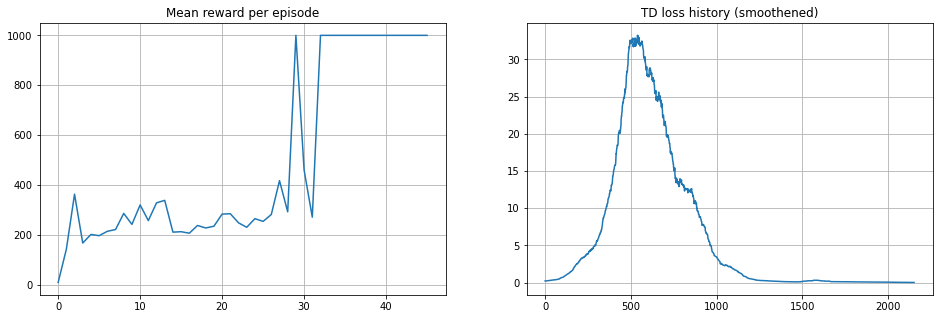

100%|███████████████████████████████████████████████████████████████████████████| 45001/45001 [06:58<00:00, 107.57it/s]


In [20]:
state = env.reset()
for step in trange(total_steps + 1):
    
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags, weights, idxs = exp_replay.sample(batch_size)
    

    # loss = <compute TD loss>
    loss = compute_td_loss_priority_replay(agent, target_network, exp_replay,
                           states, actions, rewards, next_states, done_flags, weights, idxs,              
                           gamma=0.99,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [21]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: 1000.0
Well done


**Let us record a video of trained agent**

In [22]:
def generate_animation(env, agent, save_dir):
    
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state = env.reset()
    reward = 0
    while True:
        qvalues = agent.get_qvalues([state])
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        if done or reward >=1000:
            print('Got reward: {}'.format(reward))
            break
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [23]:
# Animate learned policy
save_dir='./videos/pytorch/6_3/'
env = make_env(env_name)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)


Got reward: 1000.0


In [24]:
#TODO

# Try to run this on another environment of your choice from OpenAI Gym
# read the accompanying text and try to enahnce the network using various variants


### Summary

In this notebook we saw how to train a DQN agent with **prioritized** experience replay and target networks. We can see that using prioritized buffer speeds up the training significantly with higher scores. This is even more evident with more complex environments like Atari games. 


We can further improve this agent with additional tricks. As we go along, we will be implementing many of these variants.